<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/03_k_space_sampling/notebooks/01_cartesian_ordering_and_undersampling_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: Cartesian k-space ordering and undersampling (solutions)


---
Solutions
---
---

- **In the sequence code below, the current implementation is the solution after exercise 1.1. All other solutions are given as comments, marked with the exercise number!**

---
&nbsp;
---

In this exercise we will modify the k-space ordering for an inversion recovery (IR) gradient echo sequence, which is a simple modification of the default GRE sequence by adding an inversion pre-pulse, and conceptually similar to the MPRAGE sequence:

<img src=https://mriquestions.com/uploads/3/4/5/7/34572113/mp-rage-sequence_orig.png>

The number of acquisitions per shot is specified in `shot_length` below. The number of shots (`N_shots`) is automatically calculated before the sequence loop. Note that the `TR` parameter specified below is the time between each RF excitation pulse, and not the time between the inversion pulses as in the figure.

An important aspect of this sequence is that the signal is acquired in the transient state, i.e. the signal changes substantially between the first and last line acquired in each shot. Because of this, the ordering in k-space is actually quite important!

There are many sequences that have similar inconsistency in the acquired signal. For example, cardiac- or resperatory-triggered sequences will not be in a consistent steady-state. In turbo spin echo (TSE) the acquired signals are differently weighted by T2. And in general: motion, flow and other artifacts can have different appearances based on k-space ordering.

You can find the exercises at the bottom of this notebook!

## Initialization

In [20]:
import importlib
if importlib.util.find_spec('pypulseq') is None:
    !pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git

import math
import numpy as np
import matplotlib.pyplot as plt

import pypulseq as pp

!wget -nc https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
from utils import animate, simulate_2d, sort_data_implicit, ifft_2d, combine_coils, plot_nd

from IPython.display import HTML

File ‘utils.py’ already there; not retrieving.



# **Create, simulate, and reconstruct sequence**

**Multishot IR GRE Sequence definition**

Timing check passed successfully


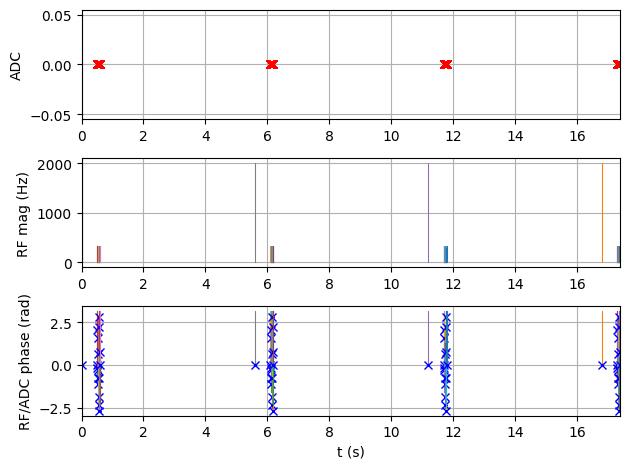

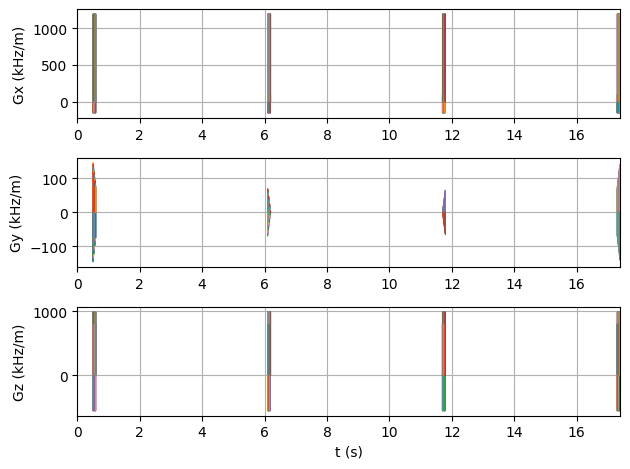

Number of blocks: 395
Number of events:
RF:     68
Gx:    192
Gy:    128
Gz:    192
ADC:     64
Delay:      0
Sequence duration: 17.386400 s
TE: 0.003020 s
TR: 0.006000 s
Flip angle: 30.00 180.00 deg
Unique k-space positions (aka cols, rows, etc.): 64 64 
Dimensions: 2
Spatial resolution: 4.00 mm
Spatial resolution: 4.00 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check passed successfully
Max gradient: 1190476 145349 987654 Hz/m == 27.96 3.41 23.20 mT/m
Max slew rate: 6265664160 1038205980 6153846154 Hz/m/s == 147.16 24.38 144.54 T/m/s
Max absolute gradient: 1553648 Hz/m == 36.49 mT/m
Max absolute slew rate: 8.20716e+09 Hz/m/s == 192.76 T/m/s


In [21]:
seq_filename = "ir_gre.seq"
animate_sequence = True

# ======
# SETUP
# ======

# Define FOV and resolution
fov = [256e-3, 256e-3, 5e-3]
Nx = 64
Ny = 64
Nz = 1

alpha = 30  # Flip angle
TI = 500e-3 # Inversion time (sec)
TD = 5000e-3 # Recovery/Dead time (sec)
TE = 3e-3  # Echo time (sec)
TR = 6e-3  # Repetition time (sec)
shot_length = 16 # Number of lines to read after each IR pulse
readout_duration = 2.56e-3 # Duration of flat area of readout gradient (sec)

ro_os = 1 # Readout oversampling
rf_spoiling_inc = 117  # RF spoiling increment

system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=150,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

# Create a new sequence object
seq = pp.Sequence(system)

# ======
# CREATE EVENTS
# ======

# Inversion pulse
rf_180 = pp.make_sinc_pulse(
    flip_angle=math.pi,
    duration=1e-3,
    apodization=0.42,
    time_bw_product=4,
    system=system
)

# Excitation pulse
rf, gz, _ = pp.make_sinc_pulse(
    flip_angle=alpha * math.pi / 180,
    duration=1e-3,
    slice_thickness=fov[2],
    apodization=0.42,
    time_bw_product=4,
    system=system,
    return_gz=True
)

delta_kx = 1 / fov[0]
delta_ky = 1 / fov[1]
delta_kz = 1 / fov[2]

# Frequency encoding gradients
gx = pp.make_trapezoid(channel="x", flat_area=Nx * delta_kx, flat_time=readout_duration, system=system)
adc = pp.make_adc(num_samples=Nx * ro_os, duration=gx.flat_time, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel="x", area=-gx.area/2 - delta_kx/2, duration=1e-3, system=system)

phase_areas_y = (np.arange(Ny) - Ny // 2) * delta_ky
phase_areas_z = (np.arange(Nz) - Nz // 2) * delta_kz


# Ex 1.1 Definite a phase encoding table (for Y only)
phase_encode_table = [i for i in range(Ny)]

# Ex 1.1 Reverse linear order
# phase_encode_table = [Ny-i-1 for i in range(Ny)]

# Ex 1.2 Linear interleaved order
# phase_encode_table = []
# for i in range(N_shots):
#     for j in range(shot_length):
#         phase_encode_table.append(i + j*N_shots)

# Ex 1.3: Zig Zag order
# assert Ny % shot_length == 0, 'zig zag pattern Ny to be a multiple of shot_length'
# N_shots = math.ceil(Ny*Nz / shot_length)
# phase_encode_table = []
# for i in range(N_shots):
#     if i % 2 == 0:
#         for j in range(shot_length):
#             phase_encode_table.append(i*shot_length + j)
#     else:
#         for j in range(shot_length-1,-1,-1):
#             phase_encode_table.append(i*shot_length + j)

# Ex 1.3: Center-out order
# assert N_shots%2 == 0, 'Number of shots must be even'
# phase_encode_table = []
# N_shots = math.ceil(Ny*Nz / shot_length)
# for i in range(N_shots):
#     for j in range(shot_length):
#         phase_encode_table.append(Ny//2 + (i//2 + j*(N_shots//2))) * (1 if (i)%2==0 else -1) - (0 if i%2 == 0 else 1))

# Ex 2.1 GRAPPA pattern with skipping every odd line, and with 12 central lines (linear order)
# phase_encode_table = [x for x in range(Ny) if x%2 == 0 or abs(Ny//2 - x) <= 6]

# Ex 2.2 Random pattern for Compressed Sensing with controllable acceleration factor and number of central lines
# import random
# central_lines = 12
# acceleration_factor = 2
# phase_encode_table = [x for x in range(Ny) if -central_lines/2 <= Ny//2 - x < central_lines/2] + random.sample([x for x in range(Ny) if abs(Ny//2 - x) > 6], int(Ny/acceleration_factor - central_lines))
# print('Acceleration factor:', Ny / len(phase_encode_table))

# Ex 3. 3D phase encoding table YZ order
# phase_encode_table = [(y,z) for y in range(Ny) for z in range(Nz)]

# Ex 3. 3D phase encoding table ZY order
# phase_encode_table = [(y,z) for z in range(Nz) for y in range(Ny)]

# Ex 3. 3D phase encoding table, center-out
# # Create the full table first
# phase_encode_table = [(y,z) for z in range(Nz) for y in range(Ny)]
# # Then sort according to the squared distance of the phase encoding areas from the center of k-space
# phase_encode_table = sorted(phase_encode_table, key=lambda x:phase_areas_y[x[0]]**2 + phase_areas_z[x[1]]**2)



# Ex 2. Changed the calculation for N_pe (total number of phase encoding lines) based on the length of the table, which can decrease with undersampling
# N_pe = Ny*Nz
N_pe = len(phase_encode_table)


# gradient spoiling
gx_spoil = pp.make_trapezoid(channel="x", area=2 * Nx * delta_kx, system=system)
gz_spoiler_area = 4 / fov[2]

# Calculate timing
delay_TI = (
    math.ceil(
        (
            TI
            - (pp.calc_duration(rf_180) - pp.calc_rf_center(rf_180)[0] - rf_180.delay)
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)

delay_TD = math.ceil(TD / seq.grad_raster_time) * seq.grad_raster_time

delay_TE = (
    math.ceil(
        (
            TE
            - (pp.calc_duration(gz, rf) - pp.calc_rf_center(rf)[0] - rf.delay)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx) / 2
            - pp.eps
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
delay_TR = (
    math.ceil(
        (
            TR
            - pp.calc_duration(rf, gz)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx)
            - delay_TE
            - pp.calc_duration(gx_pre)
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)

# ======
# CONSTRUCT SEQUENCE
# ======

N_shots = math.ceil(N_pe / shot_length)
pe_index = 0

# Outer loop over shots
for shot in range(N_shots):
    # Inversion pre-pulse
    seq.add_block(rf_180)

    # Wait for inversion time
    seq.add_block(pp.make_delay(delay_TI))

    rf_phase = 0
    rf_inc = 0

    # Inner over phase-encodes within shot
    for i in range(shot_length):
        rf.phase_offset = rf_phase / 180 * np.pi
        adc.phase_offset = rf_phase / 180 * np.pi
        rf_inc = (rf_inc + rf_spoiling_inc) % 360.0
        rf_phase = (rf_phase + rf_inc) % 360.0

        # Slice-selective RF excitation
        seq.add_block(rf, gz)

        # Wait for TE
        seq.add_block(pp.make_delay(delay_TE))

        # Readout pre-phaser, slice selection rephaser, and phase-encoding

        # Ex 1.1. Changed gy_pre to use phase_encode_table
        gy_pre = pp.make_trapezoid(channel='y', area=phase_areas_y[phase_encode_table[pe_index]], duration=pp.calc_duration(gx_pre), system=system)

        # Ex 3. Changed gy_pre to use Y-index of 3D phase_encode_table with (Y,Z) indices
        # gy_pre = pp.make_trapezoid(channel='y', area=phase_areas_y[phase_encode_table[pe_index][0]], duration=pp.calc_duration(gx_pre), system=system)

        gz_pre = pp.make_trapezoid(channel='z', area=phase_areas_z[0] - gz.area / 2, duration=pp.calc_duration(gx_pre), system=system)

        # Ex 3. Changed gz_pre to use Z-index of 3D phase_encode_table with (Y,Z) indices
        # gz_pre = pp.make_trapezoid(channel='z', area=phase_areas_z[phase_encode_table[pe_index][1]] - gz.area / 2, duration=pp.calc_duration(gx_pre), system=system)
        seq.add_block(gx_pre, gy_pre, gz_pre)

        # Readout gradient
        seq.add_block(gx, adc)

        # GX/GZ spoilers and phase encoding balancing
        # Ex 1.1. Changed gy_reph to use phase_encode_table
        gy_reph = pp.make_trapezoid(channel='y', area=-phase_areas_y[phase_encode_table[pe_index]], duration=pp.calc_duration(gx_pre), system=system)

        # Ex 3. Changed gy_reph to use Y-index of 3D phase_encode_table with (Y,Z) indices
        # gy_reph = pp.make_trapezoid(channel='y', area=-phase_areas_y[phase_encode_table[pe_index][0]], duration=pp.calc_duration(gx_pre), system=system)

        gz_reph = pp.make_trapezoid(channel='z', area=-phase_areas_z[0] + gz_spoiler_area, duration=pp.calc_duration(gx_pre), system=system) # Z Rephaser and spoiler

        # Ex 3. Changed gz_reph to use Z-index of 3D phase_encode_table with (Y,Z) indices
        # gz_reph = pp.make_trapezoid(channel='z', area=-phase_areas_z[phase_encode_table[pe_index][1]] + gz_spoiler_area, duration=pp.calc_duration(gx_pre), system=system) # Z Rephaser and spoiler

        seq.add_block(gx_spoil, gy_reph, gz_reph)

        # Wait for TR
        seq.add_block(pp.make_delay(delay_TR))
        pe_index += 1

        # Stop sequence once we measured N_pe phase encodes
        if pe_index == N_pe:
            break

    # Wait for dead time
    if shot != N_shots - 1:
      seq.add_block(pp.make_delay(delay_TD))


# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# ======
# VISUALIZATION
# ======
seq.plot()

# Test report
print(seq.test_report())

# Write sequence
seq.set_definition(key="FOV", value=fov)
seq.write(seq_filename)

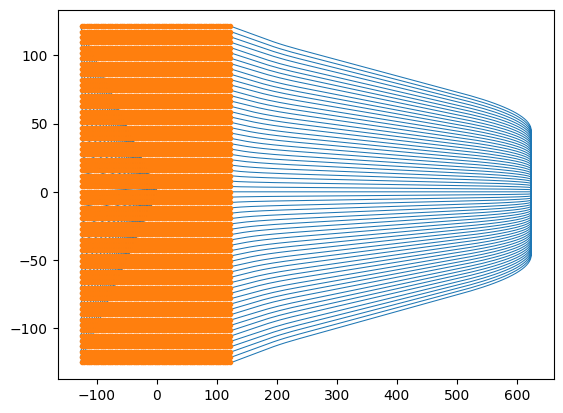

In [22]:
# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'.')

**Animate trajectory**

In [23]:
if animate_sequence:
    ani = animate(seq, show=False, dt=seq.duration()[0] / 10, plot_window=seq.duration()[0], fps=10, show_progress=True)
    display(HTML(ani.to_html5_video()))

  0%|          | 0/10 [00:00<?, ?it/s]

**Run MR-zero simulation**

The code below simulates the whole sequence, and shows the magnitude of the raw k-space profiles in acquisition order.

/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


Calculating repetition 68 / 68 - done


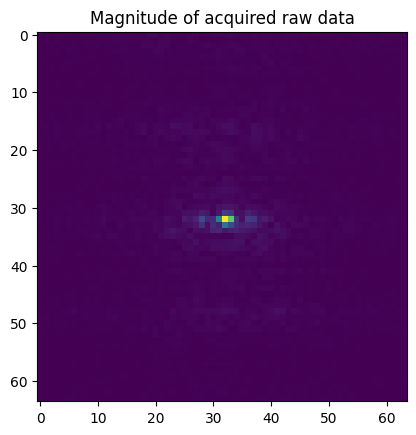

In [24]:
# Simulate sequence
kdata = simulate_2d(seq, sim_size=[128,128], noise_level=0.5, n_coils=4).conj()

# Display raw data profiles
plt.figure()
plt.imshow(abs(kdata[0]))
plt.title('Magnitude of acquired raw data');

**Reconstruct simulated data**

Automatically detected matrix size: (1, 64, 64)


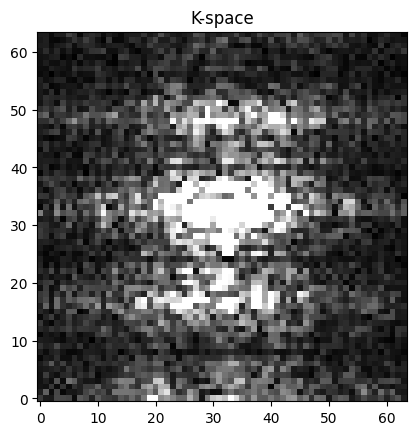

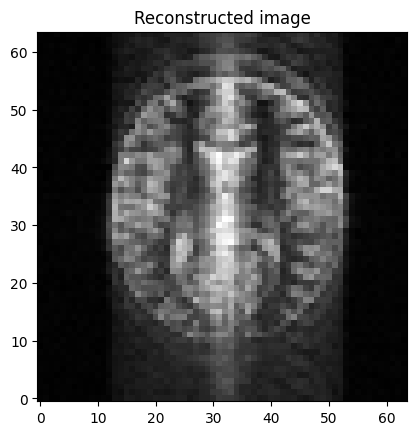

In [25]:
kspace = sort_data_implicit(kdata, seq)
im = ifft_2d(kspace)
rec = combine_coils(im)

# Plot k-space (only for first receive channel)
plot_nd(kspace[0], vmax=10)
plt.title('K-space')

# Plot reconstructed image
plot_nd(rec)
plt.title('Reconstructed image');

**Parallel imaging and CS reconstruction**

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

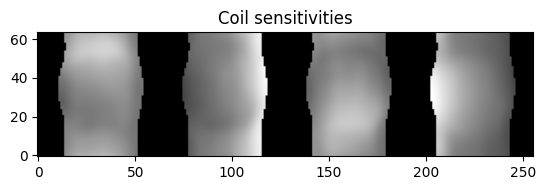

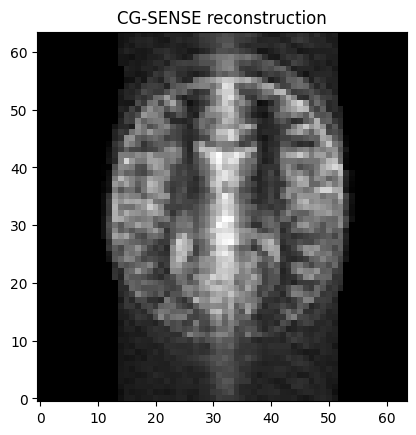

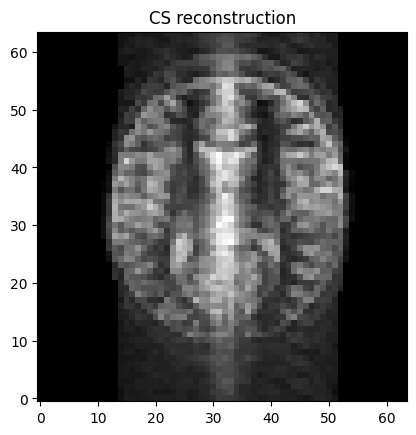

In [26]:
from sigpy.mri.app import L1WaveletRecon, EspiritCalib, SenseRecon, TotalVariationRecon

# Only enable this reconstruction if multiple coils were simulated (n_coils argument in simulate_2d)
if kspace.shape[0] > 1:
    # Compute coil sensitivities from center of k-space
    app = EspiritCalib(kspace, calib_width=12, crop=0.95)
    csm = app.run()

    # Plot coil sensitivities
    plot_nd(csm)
    plt.title('Coil sensitivities')

    # CG-SENSE reconstruction with small L2 penalty (weighted by lamda)
    app = SenseRecon(kspace, csm, lamda=0.01)
    rec = app.run()

    # Plot reconstruction
    plot_nd(rec)
    plt.title('CG-SENSE reconstruction');

    # CS reconstruction with total variation penalty (weighted by lamda)
    app = TotalVariationRecon(kspace, csm, lamda=0.1)
    rec = app.run()

    # Plot reconstruction
    plot_nd(rec)
    plt.title('CS reconstruction');

# Exercises

Note: If you want the whole notebook to run a bit faster, consider setting `animate_sequence = False` at the top of the sequence definition.

## 1. Profile ordering

The sequence above implements a linear order in phase-encoding in the Y direction. Phase-encoding in the Z-direction is disabled, but the building blocks are there to add it later.

The desired areas of the phase-encoding gradient are encoded in the array `phase_areas_y`. As it is now, the order is linear because `pe_index` increases linearly.

!! Note that indexing in arrays/lists in Python starts with 0 !!

**1.1 Phase encoding table**

- Implement a list that defines the scan order of the sequence. For consistency with the next exercise, name it `phase_encode_table`. Fill it with a simple linear ordering for now (i.e. such that `phase_encode_table[i] = i`).

- Now use `phase_encode_table` in the Y phase-encoding gradient instead of using `pe_index` directly, i.e. instead of `phase_areas_y[pe_index]`, use `phase_areas_y[ ... something else ... ]`. Do not modify `pe_index`, because it is also used later to determine the end of the scan!

- Check that the encoded k-space is correct and that you can modify the phase encoding order, for example by reversing the order (i.e. `phase_encode_table[i] = Ny-i-1`). To use the animation above to better visualize the order, set `TI` and `TD` to `5e-3`, and/or decrease `dt` to render more frames. Do not forget to modify them back! (`TI = 500e-3`, `TD = 5000e-3`)

Note that the artifacts in the reconstructed k-space and image change with the ordering.

**1.2 Profile ordering**

With the phase encoding table, we can now implement arbitrary orderings. Note that our 64 phase-encode lines are divided in 4 shots of 16 lines, and that the signal varies a lot over these shots because the signal is not in steady-state.

We can mitigate some of these artifacts by changing the order, such that the signal variation over k-space is more smooth (i.e. similar signal intensities are next to each other).

In this case: Signal is high in the first lines read in each shot, and then gets lower throughout the shot.

- Implement a linear interleaved profile order. Instead of each shot encoding one section of k-space, all shots are interleaved, i.e. the first k-space line is encoded by the first line in first shot, the second k-space line by the first line in the second shot, etc.
  - Start with designing the ordering for 4 shots of 16 lines. If that came easy, you can try to the make the ordering work for any value of `Ny` and `shot_length`.

- Observe the reconstructed k-space and image. The abrupt changes in intensity in k-space should be gone, and as a result the reconstructed image looks better, although not free of artifacts!

**1.3 Advanced/optional: Different profile orders**

There are different orderings with effects comparable to the linear interleaved order. Try implementing one (or both):
- Center-out: The starts of each shot are placed in the center of k-space and then move outward. Mind that the index of the center of k-space is `Ny//2`.
  - One way to implement this pattern is to have the 1st shot encode the top half of k-space with steps of 2, the 2nd shot encode the bottom half of k-space with steps of 2, and the 3rd and 4th shots encode the same as the 1st and 2nd shots, but shifted by one sample.
  - Check that each element in the phase encoding table is unique (i.e. do not acquire the same line twice).
- Zig-zag (per shot): Place the starts and ends of the successive shots next to eachother. I.e. with 4 shots and a linear order, the 2nd and 4th shots are reversed. This places the encoding at the end of the 2nd shot next to the end of the 1st shot, and the start of the 2nd shot next to the start of the 3rd shot.

There are many more options for k-space ordering, which depend strongly on the application and pulse sequence type. Especially in 3D imaging, where there are two phase encodings dimensions, there are many possibilities.

## 2. Undersampling

Profile ordering and undersampling are very similar when it comes to implementing it in a sequence. In addition to the ordering, we now also decide whether or not to measure a given k-space line. The fewer lines we acquire, the lower the total scan time gets!

- To ignore the effects of ordering in this sequence, change `shot_length` to 1. This will make the sequence duration very long, but for now we are only interested in the simulations.

**2.1 Parallel imaging**

- With the phase encoding table as implemented in the first exercise, undersampling is trivial: Either remove unwanted phase-encodes, or never add them to the phase encoding table to begin with! You now only need to update `N_pe`, because the sequence will have less repetitions as a result.

For a simple example that skips every second line, try:

`phase_encode_table = np.arange(0,Ny,2)`

Or in pure python code using a so-called list comprehension:
`phase_encode_table = [x for x in range(Ny) if x % 2 == 0]`

Or, a few more lines of code, but easier to read:
```
phase_encode_table = []
for x in range(Ny):
    if x % 2 == 0:
        phase_encode_table.append(x)
```

- Implement a regular undersampling pattern that skips every second line, but acquires the full center of k-space (e.g. 12 lines wide). This is similar to what is used in GRAPPA parallel imaging.
  - In order to properly reconstruct an image from data acquired this way, we need information from multiple receive coils. In the simulation block, change `n_coils` to 4 (which will simulate 4 birdcage coil elements).
  - The fully sampled center of k-space will give sufficient information on the coil sensitivities, which are then used in a CG-SENSE reconstruction, an iterative parallel imaging reconstruction.
  - Note the difference between the normal reconstruction using sum-of-squares coil combination and the CG-SENSE reconstruction!

Notes:
- With the sampling pattern above, you could use the GRAPPA reconstruction algorithm. This is left as an exercise to the reader.
- Parallel imaging implementations on scanner systems that use SENSE for parallel imaging (e.g. Philips) typically acquire a separate coil calibration scan, and would not need to fully acquire the k-space center.


**2.2 Optional: Compressed sensing (CS)**

In 2.1, you could have observed that the artifacts from the regular undersampling result in replications of the image in the phase encoding direction (e.g. the image repeats every half a FOV for skipping every second line).

In CS, we use (pseudo)random undersampling pattern instead.

- Implement a random undersampling pattern. Do acquire the central 12 lines, but outside this, acquire only a random selection of half of the k-space lines. Hint: In the `random` package there is the `random.sample(list, N)` function, which samples `N` elements from `list`. Remember to `import random` first.

- What happened to the artifacts in the image?
  - What if you measure only a quarter of the lines?
  - You can set `Nx` and `Ny` to a higher number (e.g. 128) to increase the image resolution, which gives a bit more freedom in the undersampling pattern and acceleration factor.

- The CG-SENSE reconstruction will still do a reasonable job, but is affected by these different type of artifacts. The `sigpy` package includes a CS reconstruction called `TotalVariationRecon`, which attempts to enforce reconstructed images to be piecewise-constant. Replace `SenseRecon` with `TotalVariationRecon`. You can play around with the `lamda` parameter, which controls how strongly the reconstruction will enforce the piecewise-constant constraint.

Note how reconstruction quality varies with each random instance of the undersampling pattern. In CS, it is often said that "Randomness is too important to be left to chance". There exist many approaches to "random" undersampling, that still try to guarantee good reconstruction quality, regardless of the precise undersampling pattern used. Especially in 3D, there is a lot of freedom in designing the undersampling pattern, since both the Y and Z directions are phase-encoded.

Also note that here we ignored the ordering, but this is of course still important, and aligning multiple shots with random undersampling can be tricky!


## 3. Optional: 3D profile ordering

- Following the same scheme as used for phase-encoding in the Y direction, enable phase-encoding in the Z direction. Note that `pe_index` will now reach much higher numbers, and the phase encoding table needs to be larger as a result.
  - Either add a second `phase_encode_table` for the Z direction, or enter (Y,Z) tuples into one table for both Y and Z directions (e.g. [(0,0), (0,1), etc.])
  - Adjust the `gz_pre` and `gz_reph` gradients accordingly (and `gy_pre` and `gy_reph` if you use a single table).

- Set `Nz` to a low number to test the sequence. Increase the Z-component of `fov` accordingly. Note that we do not simulate a full 3D object, so the Z-direction with not look quite correct. Import and use `ifft_3d` to make the reconstruction do a 3D IFFT, and adjust the plotting to plot one slice (usually the central slice (`Nz//2`)).

- Think of and try to implement different 3D profile ordering schemes.
  - Common ones seen on the scanner and literature:
    - Linear YZ or ZY ordering
    - Center-out
    - https://mriquestions.com/k-space-trajectories.html

**Final notes**

- In your own sequences you may not need the full flexibility of many ordering schemes and undersampling options. There is no shame in just hardcoding what works for your sequence!
- When combining undersampling and profile ordering, it is usually best to first deal with the undersampling, and then impose order on the phase-encodes that you actually want to measure.